# Generating animals with DCGAN based on AFHQ dataset

AFHQ dataset contains images of cats, dogs and wildlife (lions, tigers) focused on their faces.

Link to data readme: https://github.com/clovaai/stargan-v2/blob/master/README.md#animal-faces-hq-dataset-afhq

After exploring dataset notes:
- really high quality images (512x512)
- large amount of images (15k) but only 3 classes
- nicely positioned on face


In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


# Data loading
Images are explored and processed in `Ganimals - Dataset loading and processing.ipynb` notebook.

In [3]:
INPUT_PATH = '/content/gdrive/MyDrive/ganimals/' # to saved npz data
OUTPUT_PATH = '/content/gdrive/MyDrive/ganimals/dcgan_afhq/' # for saving intermediate models and images

In [4]:
def load_data(path_to_npz):
  '''
  Load images from numpy compressed array previously created.

  Args:
    path_to_npz - str, path to directory with file name where .npz file is located

  '''
  data = np.load(path_to_npz)
  animals = data['arr_0']
  print('Loaded: ', animals.shape)

  return animals

def preprocess_images(animals):
  '''
  Preprocess images stored in array. Images are required to be normalized to [-1, 1] for generator of GAN. Shuffle the images.

  Args:
    animals - numpy array, stored images of dataset

  '''
  animals = (animals.astype('float32') - 127.5) / 127.5  # normalize the images to [-1, 1] 
  np.random.shuffle(animals) 

  return animals

In [5]:
afhq_animals = load_data(INPUT_PATH + 'afhq_animals.npz')
afhq_animals = preprocess_images(afhq_animals)

Loaded:  (15803, 80, 80, 3)


In [6]:
# TESTS DATA LOADING

def test_data_laoding(images, expected_size):

  assert images.shape[1:] == (80, 80, 3) # test img shape
  assert images.shape[0] > expected_size # test size approx

def test_normalization(images):
  assert (images <= 1).all() & (images >= -1).all(), 'Data  should be normalized and range from -1 to 1'



test_data_laoding(afhq_animals, 15000)
test_normalization(afhq_animals)

# DCGAN - simple implementation
Here I didn't use DCGAN implementation from dcgan.py script, but initially a code based on https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/

Because of lack of time to train it again with my implementation I leave it as it is. Complete code with training output is below.

In [5]:
import tensorflow as tf

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

In [13]:
batch_size = 256
num_channels = 3
image_size = 80
latent_dim = 100

# Helper functions

In [ ]:
# select real samples from dataset

def batch_real_samples(dataset, n_samples):

	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = np.ones((n_samples, 1)) # create 'real' class labels (1)

	return X, y

In [1]:
# generate points in latent space as input for the generator
# those are just noise from normal distribution

def generate_latent_points(latent_dim, n_samples):

	x_input = np.random.randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
 
	return x_input

def batch_fake_samples(g_model, latent_dim, n_samples):

	x_input = generate_latent_points(latent_dim, n_samples)
	
	X = g_model.predict(x_input) # predict outputs
	y = np.zeros((n_samples, 1)) # create 'fake' class labels (0)

	return X, y

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(image_size, image_size, num_channels)):

	model = Sequential()

	model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same')) 	# downsample to 40x40
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same')) # downsample to 20x30
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same')) # downsample to 10x10
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same')) # downsample to 5x5
	model.add(LeakyReLU(alpha=0.2))

	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
 
	return model

# define the standalone generator model
def define_generator(latent_dim):
	
	model = Sequential()
	# foundation for 5x5 feature maps
	n_nodes = 128 * 5 * 5
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((5, 5, 128)))
	
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # upsample to 10x10
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # upsample to 20x20
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # upsample to 40x40
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # upsample to 80x80
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(3, (5,5), activation='tanh', padding='same')) # output layer 80x80x3
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	
	model = Sequential() # connect them
	model.add(g_model)
	model.add(d_model)
	
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt) # compile model

	return model

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=batch_size):

	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
 
	for i in range(n_epochs):
		for j in range(bat_per_epo): # enumerate batches over the training set
			
			X_real, y_real = batch_real_samples(dataset, half_batch)
			d_loss1, _ = d_model.train_on_batch(X_real, y_real) # update discriminator model weights

			X_fake, y_fake = batch_fake_samples(g_model, latent_dim, half_batch)
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake) # update discriminator model weights
			
      # prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			
      
			y_gan = np.ones((n_batch, 1)) # create inverted labels for the fake samples
			g_loss = gan_model.train_on_batch(X_gan, y_gan) # update the generator via the discriminator's error

			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
   
		# evaluate the model performance
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
   

# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
	
	examples = (examples + 1) / 2.0 # scale from [-1,1] to [0,1]

	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i])
  
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):

	X_real, y_real = batch_real_samples(dataset, n_samples)
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0) # evaluate discriminator on real examples

	x_fake, y_fake = batch_fake_samples(g_model, latent_dim, n_samples)	
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0) # evaluate discriminator on fake examples
 
	
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
 
	save_plot(x_fake, epoch)
	filename = 'generator_model_%03d.h5' % (epoch+1)
 
	g_model.save(filename)

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# to save intermediate models and images to drive
os.chdir(OUTPUT_PATH)

In [ ]:
d_model = define_discriminator()
g_model = define_generator(latent_dim)

gan_model = define_gan(g_model, d_model)

# train model
train(g_model, d_model, gan_model, afhq_animals, latent_dim, n_batch=batch_size)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 1s 10ms/step
>1, 1/112, d1=0.690, d2=0.696 g=0.692
2/2 [==============================] - 0s 18ms/step
>1, 2/112, d1=0.575, d2=0.699 g=0.690
2/2 [==============================] - 0s 18ms/step
>1, 3/112, d1=0.267, d2=0.718 g=0.676
2/2 [==============================] - 0s 18ms/step
>1, 4/112, d1=0.016, d2=0.754 g=0.679
2/2 [==============================] - 0s 19ms/step
>1, 5/112, d1=0.005, d2=0.733 g=0.698
2/2 [==============================] - 0s 18ms/step
>1, 6/112, d1=0.012, d2=0.686 g=0.720
2/2 [==============================] - 0s 18ms/step
>1, 7/112, d1=0.022, d2=0.667 g=0.755
2/2 [==============================] - 0s 20ms/step
>1, 8/112, d1=0.002, d2=0.633 g=0.852
2/2 [==============================] - 0s 18ms/step
>1, 9/112, d1=0.002, d2=0.566 g=1.037
2/2 [==============================] - 0s 18ms/step
>1, 10/112, d1=0.025, d2=0.508 g=1.127
2/2 [==============================] - 0s 18ms/step
>1, 11/112, d1=0.000, d2=0.370 g=1.696
2/2 [===

2/2 [==============================] - 0s 23ms/step
>11, 1/112, d1=0.137, d2=0.044 g=4.628
2/2 [==============================] - 0s 19ms/step
>11, 2/112, d1=0.089, d2=0.104 g=5.096
2/2 [==============================] - 0s 18ms/step
>11, 3/112, d1=0.055, d2=0.018 g=5.334
2/2 [==============================] - 0s 18ms/step
>11, 4/112, d1=0.039, d2=0.039 g=5.247
2/2 [==============================] - 0s 18ms/step
>11, 5/112, d1=0.010, d2=0.026 g=5.394
2/2 [==============================] - 0s 18ms/step
>11, 6/112, d1=0.039, d2=0.044 g=4.562
2/2 [==============================] - 0s 19ms/step
>11, 7/112, d1=0.098, d2=0.210 g=6.158
2/2 [==============================] - 0s 18ms/step
>11, 8/112, d1=0.188, d2=0.045 g=3.917
2/2 [==============================] - 0s 18ms/step
>11, 9/112, d1=0.021, d2=0.118 g=5.172
2/2 [==============================] - 0s 20ms/step
>11, 10/112, d1=0.104, d2=0.038 g=4.666
2/2 [==============================] - 0s 18ms/step
>11, 11/112, d1=0.044, d2=0.126 g=5.6

2/2 [==============================] - 0s 29ms/step
>21, 1/112, d1=0.339, d2=0.335 g=3.694
2/2 [==============================] - 0s 18ms/step
>21, 2/112, d1=0.305, d2=0.131 g=3.031
2/2 [==============================] - 0s 19ms/step
>21, 3/112, d1=0.105, d2=0.248 g=3.632
2/2 [==============================] - 0s 18ms/step
>21, 4/112, d1=0.205, d2=0.101 g=3.805
2/2 [==============================] - 0s 19ms/step
>21, 5/112, d1=0.146, d2=0.180 g=4.098
2/2 [==============================] - 0s 19ms/step
>21, 6/112, d1=0.393, d2=0.270 g=4.059
2/2 [==============================] - 0s 19ms/step
>21, 7/112, d1=0.171, d2=0.152 g=4.350
2/2 [==============================] - 0s 19ms/step
>21, 8/112, d1=0.147, d2=0.078 g=4.041
2/2 [==============================] - 0s 18ms/step
>21, 9/112, d1=0.072, d2=0.172 g=4.565
2/2 [==============================] - 0s 18ms/step
>21, 10/112, d1=0.231, d2=0.293 g=5.439
2/2 [==============================] - 0s 18ms/step
>21, 11/112, d1=0.551, d2=0.123 g=3.5

2/2 [==============================] - 0s 29ms/step
>31, 1/112, d1=0.279, d2=0.190 g=4.318
2/2 [==============================] - 0s 18ms/step
>31, 2/112, d1=0.254, d2=0.132 g=4.026
2/2 [==============================] - 0s 18ms/step
>31, 3/112, d1=0.241, d2=0.210 g=4.237
2/2 [==============================] - 0s 19ms/step
>31, 4/112, d1=0.136, d2=0.152 g=4.510
2/2 [==============================] - 0s 19ms/step
>31, 5/112, d1=0.386, d2=0.207 g=4.201
2/2 [==============================] - 0s 18ms/step
>31, 6/112, d1=0.260, d2=0.245 g=4.018
2/2 [==============================] - 0s 18ms/step
>31, 7/112, d1=0.247, d2=0.231 g=3.749
2/2 [==============================] - 0s 18ms/step
>31, 8/112, d1=0.224, d2=0.203 g=4.227
2/2 [==============================] - 0s 19ms/step
>31, 9/112, d1=0.198, d2=0.202 g=4.704
2/2 [==============================] - 0s 18ms/step
>31, 10/112, d1=0.314, d2=0.220 g=3.960
2/2 [==============================] - 0s 18ms/step
>31, 11/112, d1=0.408, d2=0.292 g=3.6

2/2 [==============================] - 0s 29ms/step
>41, 1/112, d1=0.172, d2=0.129 g=3.526
2/2 [==============================] - 0s 18ms/step
>41, 2/112, d1=0.177, d2=0.393 g=4.545
2/2 [==============================] - 0s 18ms/step
>41, 3/112, d1=0.718, d2=0.337 g=4.154
2/2 [==============================] - 0s 19ms/step
>41, 4/112, d1=0.196, d2=0.082 g=3.362
2/2 [==============================] - 0s 19ms/step
>41, 5/112, d1=0.159, d2=0.280 g=4.020
2/2 [==============================] - 0s 18ms/step
>41, 6/112, d1=0.294, d2=0.153 g=3.745
2/2 [==============================] - 0s 19ms/step
>41, 7/112, d1=0.310, d2=0.243 g=3.376
2/2 [==============================] - 0s 17ms/step
>41, 8/112, d1=0.245, d2=0.298 g=3.974
2/2 [==============================] - 0s 18ms/step
>41, 9/112, d1=0.100, d2=0.114 g=4.733
2/2 [==============================] - 0s 19ms/step
>41, 10/112, d1=0.315, d2=0.147 g=3.967
2/2 [==============================] - 0s 19ms/step
>41, 11/112, d1=0.278, d2=0.191 g=3.3

2/2 [==============================] - 0s 20ms/step
>51, 1/112, d1=0.214, d2=0.147 g=4.363
2/2 [==============================] - 0s 19ms/step
>51, 2/112, d1=0.350, d2=0.326 g=4.082
2/2 [==============================] - 0s 19ms/step
>51, 3/112, d1=0.176, d2=0.251 g=4.125
2/2 [==============================] - 0s 19ms/step
>51, 4/112, d1=0.180, d2=0.144 g=4.277
2/2 [==============================] - 0s 19ms/step
>51, 5/112, d1=0.189, d2=0.069 g=3.241
2/2 [==============================] - 0s 19ms/step
>51, 6/112, d1=0.124, d2=0.517 g=4.368
2/2 [==============================] - 0s 18ms/step
>51, 7/112, d1=0.318, d2=0.142 g=4.092
2/2 [==============================] - 0s 18ms/step
>51, 8/112, d1=0.203, d2=0.226 g=4.401
2/2 [==============================] - 0s 19ms/step
>51, 9/112, d1=0.223, d2=0.127 g=3.430
2/2 [==============================] - 0s 18ms/step
>51, 10/112, d1=0.216, d2=0.277 g=3.694
2/2 [==============================] - 0s 18ms/step
>51, 11/112, d1=0.250, d2=0.203 g=3.7

2/2 [==============================] - 0s 19ms/step
>61, 1/112, d1=0.583, d2=0.512 g=1.763
2/2 [==============================] - 0s 18ms/step
>61, 2/112, d1=0.738, d2=0.554 g=1.561
2/2 [==============================] - 0s 18ms/step
>61, 3/112, d1=0.681, d2=0.641 g=1.719
2/2 [==============================] - 0s 19ms/step
>61, 4/112, d1=0.643, d2=0.580 g=1.719
2/2 [==============================] - 0s 19ms/step
>61, 5/112, d1=0.634, d2=0.476 g=1.817
2/2 [==============================] - 0s 20ms/step
>61, 6/112, d1=0.561, d2=0.541 g=1.860
2/2 [==============================] - 0s 18ms/step
>61, 7/112, d1=0.497, d2=0.533 g=2.175
2/2 [==============================] - 0s 19ms/step
>61, 8/112, d1=0.630, d2=0.487 g=2.039
2/2 [==============================] - 0s 19ms/step
>61, 9/112, d1=0.519, d2=0.494 g=2.103
2/2 [==============================] - 0s 21ms/step
>61, 10/112, d1=0.912, d2=0.700 g=1.759
2/2 [==============================] - 0s 18ms/step
>61, 11/112, d1=0.664, d2=0.416 g=1.7

2/2 [==============================] - 0s 23ms/step
>71, 1/112, d1=0.265, d2=0.167 g=3.534
2/2 [==============================] - 0s 18ms/step
>71, 2/112, d1=0.176, d2=0.277 g=3.401
2/2 [==============================] - 0s 19ms/step
>71, 3/112, d1=0.294, d2=0.279 g=3.455
2/2 [==============================] - 0s 19ms/step
>71, 4/112, d1=0.399, d2=0.211 g=2.948
2/2 [==============================] - 0s 19ms/step
>71, 5/112, d1=0.388, d2=0.331 g=3.195
2/2 [==============================] - 0s 19ms/step
>71, 6/112, d1=0.247, d2=0.159 g=2.811
2/2 [==============================] - 0s 18ms/step
>71, 7/112, d1=0.152, d2=0.283 g=3.026
2/2 [==============================] - 0s 19ms/step
>71, 8/112, d1=0.284, d2=0.199 g=2.991
2/2 [==============================] - 0s 18ms/step
>71, 9/112, d1=0.184, d2=0.232 g=3.054
2/2 [==============================] - 0s 18ms/step
>71, 10/112, d1=0.266, d2=0.252 g=3.076
2/2 [==============================] - 0s 18ms/step
>71, 11/112, d1=0.258, d2=0.203 g=2.9

2/2 [==============================] - 0s 26ms/step
>81, 1/112, d1=0.346, d2=0.249 g=3.954
2/2 [==============================] - 0s 20ms/step
>81, 2/112, d1=0.183, d2=0.124 g=3.658
2/2 [==============================] - 0s 19ms/step
>81, 3/112, d1=0.254, d2=0.293 g=3.559
2/2 [==============================] - 0s 19ms/step
>81, 4/112, d1=0.264, d2=0.158 g=3.153
2/2 [==============================] - 0s 18ms/step
>81, 5/112, d1=0.200, d2=0.275 g=3.035
2/2 [==============================] - 0s 18ms/step
>81, 6/112, d1=0.313, d2=0.309 g=3.404
2/2 [==============================] - 0s 19ms/step
>81, 7/112, d1=0.155, d2=0.258 g=3.988
2/2 [==============================] - 0s 20ms/step
>81, 8/112, d1=0.419, d2=0.213 g=2.975
2/2 [==============================] - 0s 19ms/step
>81, 9/112, d1=0.319, d2=0.440 g=3.755
2/2 [==============================] - 0s 18ms/step
>81, 10/112, d1=0.322, d2=0.300 g=4.414
2/2 [==============================] - 0s 18ms/step
>81, 11/112, d1=0.473, d2=0.157 g=3.0

2/2 [==============================] - 0s 19ms/step
>91, 1/112, d1=0.292, d2=0.340 g=3.889
2/2 [==============================] - 0s 19ms/step
>91, 2/112, d1=0.225, d2=0.199 g=4.482
2/2 [==============================] - 0s 20ms/step
>91, 3/112, d1=0.337, d2=0.137 g=3.366
2/2 [==============================] - 0s 19ms/step
>91, 4/112, d1=0.101, d2=0.288 g=3.676
2/2 [==============================] - 0s 20ms/step
>91, 5/112, d1=0.264, d2=0.234 g=3.813
2/2 [==============================] - 0s 19ms/step
>91, 6/112, d1=0.612, d2=0.219 g=3.797
2/2 [==============================] - 0s 19ms/step
>91, 7/112, d1=0.300, d2=0.253 g=3.813
2/2 [==============================] - 0s 19ms/step
>91, 8/112, d1=0.276, d2=0.127 g=3.388
2/2 [==============================] - 0s 20ms/step
>91, 9/112, d1=0.093, d2=0.291 g=4.494
2/2 [==============================] - 0s 18ms/step
>91, 10/112, d1=0.243, d2=0.252 g=4.297
2/2 [==============================] - 0s 19ms/step
>91, 11/112, d1=0.311, d2=0.126 g=3.6

The whole training process for 100 epochs took 2h15min on free Google Colab GPU.

# Load model

In [7]:
import tensorflow as tf
from keras.models import load_model
import matplotlib.image as mpimg

In [14]:
generator_dcgan = load_model(OUTPUT_PATH + 'generator_model_100.h5') # pick best performing model based on saved plots while training

Check corresponding generated images for this model.

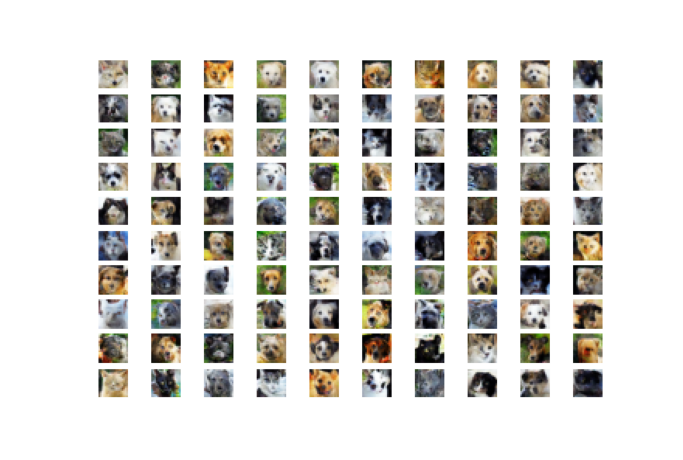

In [15]:
img = mpimg.imread(OUTPUT_PATH + 'generated_plot_e100.png')

plt.figure(figsize=(12,12))
plt.imshow(img)
plt.axis('off')
plt.show()

Check generation of new images

1/1 [==============================] - 2s 2s/step


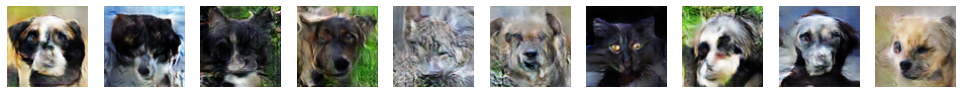

In [16]:
def generate_image(generator, n, latent_dim=latent_dim):
  # sample noise for the interpolation.
  interpolation_noise = tf.random.normal(shape=(n, latent_dim))
  fake_img = generator_dcgan.predict(interpolation_noise)

  return fake_img

def plot_generated(examples, n):
  examples = (examples + 1)/2.0

  plt.figure(figsize=(17,17))
  for i in range(n):

    plt.subplot(1, n, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i])
  
  plt.show()

# generate some individual examples
n = 10
img = generate_image(generator_dcgan, n)
plot_generated(img, n)

## Exploring latent space and interpolation

We can then generate two points in the latent space, perform the interpolation, then generate an image for each interpolated vector. The result will be a series of images that transition between the two original images.

There are two interpolation methods that can be used for that
1. Linear interpolation with linspace() 
2. Spherical linear interpolation with slerp() - that ensures the curving of the space is taken into account.

Below both of those methods are explored with examples of animals transitioning from one to another.

In [17]:
# spherical linear interpolation (slerp)
def slerp(val, low, high):
	omega = np.arccos(np.clip(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)), -1, 1))
	so = np.sin(omega)
	if so == 0:
		return (1.0-val) * low + val * high
		
	return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega) / so * high

def interpolate_points(p1, p2, n_steps=10, if_slerp=True):
	# interpolate ratios between the points
  ratios = np.linspace(0, 1, num=n_steps)

  vectors = list()
  if if_slerp:
    vectors = [slerp(ratio, p1, p2) for ratio in ratios] # slerp interpolation
  else:
    vectors = [(1.0 - ratio) * p1 + ratio * p2 for ratio in ratios] # uniform interpolation between two points in latent space
    
  return np.asarray(vectors)


def display_interpolated(num_interpolation, n_steps=10, if_slerp=False):
  interpolation_noise = tf.random.normal(shape=(num_interpolation*2, latent_dim))
  interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation*2, latent_dim))

  for i in range(0, 2*num_interpolation, 2):
    interpolated = interpolate_points(interpolation_noise[i], interpolation_noise[i+1], n_steps, if_slerp)
    X = generator_dcgan.predict(interpolated)
    plot_generated(X, n_steps)

1/1 [==============================] - 1s 597ms/step


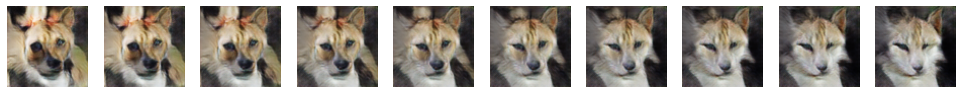

1/1 [==============================] - 1s 555ms/step


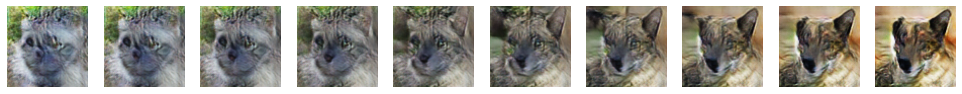

1/1 [==============================] - 0s 476ms/step


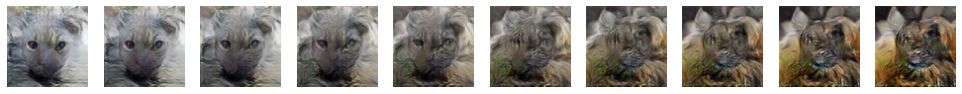

1/1 [==============================] - 0s 470ms/step


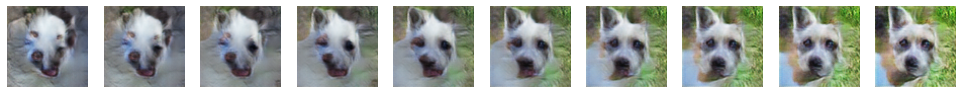

1/1 [==============================] - 0s 453ms/step


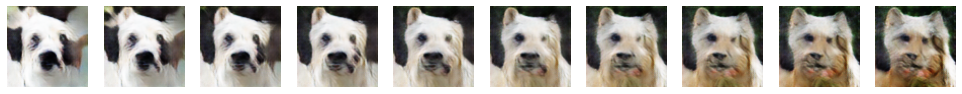

In [18]:
display_interpolated(num_interpolation=5, n_steps=10, if_slerp=False)

1/1 [==============================] - 1s 748ms/step


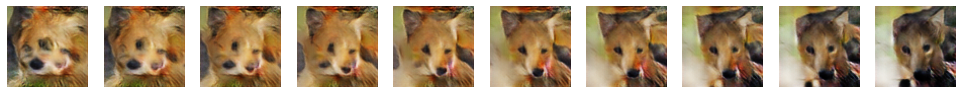

1/1 [==============================] - 0s 467ms/step


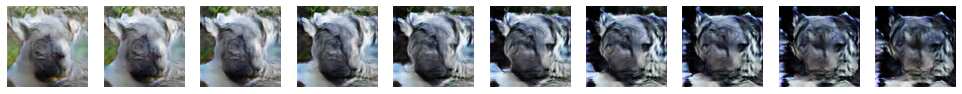

1/1 [==============================] - 0s 473ms/step


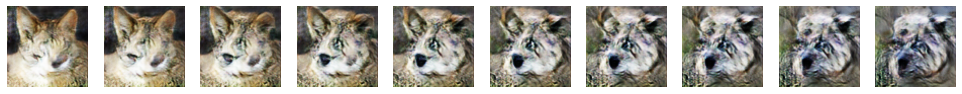

1/1 [==============================] - 0s 439ms/step


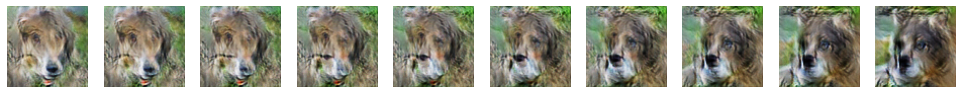

1/1 [==============================] - 0s 453ms/step


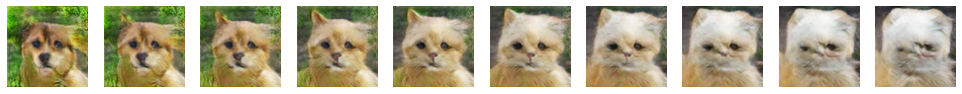

In [19]:
# slerp
display_interpolated(num_interpolation=5, n_steps=10, if_slerp=True)

# Notes
AFHQ is dataset of high quality images, but low variation in classes (dog, cat, wildlife). Although images generated during training looked blurry, I was surprised to see that newly generated images from trained model are good quality and distinct.

Model tried to combine different animals, but rather whole parts of it - like half of the face can be seen is coming from different animal usually or only a mouth or even whole face looks like pasted onto some other animal with different ears.

The important thing here is that it can be seen that they are animals and model combined them into some sort of less fine-grained hybrids. Therefore, the goal was achieved. 

Interpolation between images using latent space yielded interesting results. Some of the middle images (interpolated) look better than the end images, icorporating some features like eyes from first image that were not positioned properly or present on second image.


